<a href="https://colab.research.google.com/github/Sablabra/Option-pricing-masterthesis/blob/main/Savine_Huge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    %matplotlib notebook
except Exception:
    pass

# import and test
import tensorflow as tf2
print("TF version =", tf2.__version__)

# we want TF 2.x
assert tf2.__version__ >= "2.0"

# disable eager execution etc
tf = tf2.compat.v1
tf.disable_eager_execution()

# disable annoying warnings
tf.logging.set_verbosity(tf.logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

# make sure we have GPU support
print("GPU support = ", tf.test.is_gpu_available())

# import other useful libs
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
from tqdm import tqdm_notebook

# representation of real numbers in TF, change here for 32/64 bits
real_type = tf.float32
# real_type = tf.float64

TF version = 2.5.0
GPU support =  False


In [ ]:
def vanilla_net(
    input_dim,      # dimension of inputs, e.g. 10
    hidden_units,   # units in hidden layers, assumed constant, e.g. 20
    hidden_layers,  # number of hidden layers, e.g. 4
    seed):          # seed for initialization or None for random
    
    # set seed
    tf.set_random_seed(seed)
    
    # input layer
    xs = tf.placeholder(shape=[None, input_dim], dtype=real_type)
    
    # connection weights and biases of hidden layers
    ws = [None]
    bs = [None]
    # layer 0 (input) has no parameters
    
    # layer 0 = input layer
    zs = [xs] # eq.3, l=0
    
    # first hidden layer (index 1)
    # weight matrix
    ws.append(tf.get_variable("w1", [input_dim, hidden_units], \
        initializer = tf.variance_scaling_initializer(), dtype=real_type))
    # bias vector
    bs.append(tf.get_variable("b1", [hidden_units], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # graph
    zs.append(zs[0] @ ws[1] + bs[1]) # eq. 3, l=1
    
    # second hidden layer (index 2) to last (index hidden_layers)
    for l in range(1, hidden_layers): 
        ws.append(tf.get_variable("w%d"%(l+1), [hidden_units, hidden_units], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
        bs.append(tf.get_variable("b%d"%(l+1), [hidden_units], \
            initializer = tf.zeros_initializer(), dtype=real_type))
        zs.append(tf.nn.softplus(zs[l]) @ ws[l+1] + bs[l+1]) # eq. 3, l=2..L-1

    # output layer (index hidden_layers+1)
    ws.append(tf.get_variable("w"+str(hidden_layers+1), [hidden_units, 1], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
    bs.append(tf.get_variable("b"+str(hidden_layers+1), [1], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # eq. 3, l=L
    zs.append(tf.nn.softplus(zs[hidden_layers]) @ ws[hidden_layers+1] + bs[hidden_layers+1]) 
    
    # result = output layer
    ys = zs[hidden_layers+1]
    
    # return input layer, (parameters = weight matrices and bias vectors), 
    # [all layers] and output layer
    return xs, (ws, bs), zs, ys

In [ ]:
# compute d_output/d_inputs by (explicit) backprop in vanilla net
def backprop(
    weights_and_biases, # 2nd output from vanilla_net() 
    zs):                # 3rd output from vanilla_net()
    
    ws, bs = weights_and_biases
    L = len(zs) - 1
    
    # backpropagation, eq. 4, l=L..1
    zbar = tf.ones_like(zs[L]) # zbar_L = 1
    for l in range(L-1, 0, -1):
        zbar = (zbar @ tf.transpose(ws[l+1])) * tf.nn.sigmoid(zs[l]) # eq. 4
    # for l=0
    zbar = zbar @ tf.transpose(ws[1]) # eq. 4
    
    xbar = zbar # xbar = zbar_0
    
    # dz[L] / dx
    return xbar    

# combined graph for valuation and differentiation
def twin_net(input_dim, hidden_units, hidden_layers, seed):
    
    # first, build the feedforward net
    xs, (ws, bs), zs, ys = vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # then, build its differentiation by backprop
    xbar = backprop((ws, bs), zs)
    
    # return input x, output y and differentials d_y/d_z
    return xs, ys, xbar

In [ ]:
def vanilla_training_graph(input_dim, hidden_units, hidden_layers, seed):
    
    # net
    inputs, weights_and_biases, layers, predictions = \
        vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # backprop even though we are not USING differentials for training
    # we still need them to predict derivatives dy_dx 
    derivs_predictions = backprop(weights_and_biases, layers)
    
    # placeholder for labels
    labels = tf.placeholder(shape=[None, 1], dtype=real_type)
    
    # loss 
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    # optimizer
    learning_rate = tf.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary 
    return inputs, labels, predictions, derivs_predictions, learning_rate, loss, optimizer.minimize(loss)

# training loop for one epoch
def vanilla_train_one_epoch(# training graph from vanilla_training_graph()
                            inputs, labels, lr_placeholder, minimizer,   
                            # training set 
                            x_train, y_train,                           
                            # params, left to client code
                            learning_rate, batch_size, session):        
    
    m, n = x_train.shape
    
    # minimization loop over mini-batches
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

In [ ]:
def diff_training_graph(
    # same as vanilla
    input_dim, 
    hidden_units, 
    hidden_layers, 
    seed, 
    # balance relative weight of values and differentials 
    # loss = alpha * MSE(values) + beta * MSE(greeks, lambda_j) 
    # see online appendix
    alpha, 
    beta,
    lambda_j):
    
    # net, now a twin
    inputs, predictions, derivs_predictions = twin_net(input_dim, hidden_units, hidden_layers, seed)
    
    # placeholder for labels, now also derivs labels
    labels = tf.placeholder(shape=[None, 1], dtype=real_type)
    derivs_labels = tf.placeholder(shape=[None, derivs_predictions.shape[1]], dtype=real_type)
    
    # loss, now combined values + derivatives
    loss = alpha * tf.losses.mean_squared_error(labels, predictions) \
    + beta * tf. losses.mean_squared_error(derivs_labels * lambda_j, derivs_predictions * lambda_j)
    
    # optimizer, as vanilla
    learning_rate = tf.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary tensors, including derivatives
    # predictions and labels
    return inputs, labels, derivs_labels, predictions, derivs_predictions, \
            learning_rate, loss, optimizer.minimize(loss)

def diff_train_one_epoch(inputs, labels, derivs_labels, 
                         # graph
                         lr_placeholder, minimizer,             
                         # training set, extended
                         x_train, y_train, dydx_train,          
                         # params
                         learning_rate, batch_size, session):   
    
    m, n = x_train.shape
    
    # minimization loop, now with Greeks
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            derivs_labels: dydx_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

In [ ]:
def train(description,
          # neural approximator
          approximator,              
          # training params
          reinit=True, 
          epochs=100, 
          # one-cycle learning rate schedule
          learning_rate_schedule=[    (0.0, 1.0e-8), \
                                      (0.2, 0.1),    \
                                      (0.6, 0.01),   \
                                      (0.9, 1.0e-6), \
                                      (1.0, 1.0e-8)  ], 
          batches_per_epoch=16,
          min_batch_size=256,
          # callback function and when to call it
          callback=None,           # arbitrary callable
          callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
    # batching
    batch_size = max(min_batch_size, approximator.m // batches_per_epoch)
    
    # one-cycle learning rate sechedule
    lr_schedule_epochs, lr_schedule_rates = zip(*learning_rate_schedule)
            
    # reset
    if reinit:
        approximator.session.run(approximator.initializer)
    
    # callback on epoch 0, if requested
    if callback and 0 in callback_epochs:
        callback(approximator, 0)
        
    # loop on epochs, with progress bar (tqdm)
    for epoch in tqdm_notebook(range(epochs), desc=description):
        
        # interpolate learning rate in cycle
        learning_rate = np.interp(epoch / epochs, lr_schedule_epochs, lr_schedule_rates)
        
        # train one epoch
        
        if not approximator.differential:
        
            vanilla_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                learning_rate, 
                batch_size, 
                approximator.session)
        
        else:
        
            diff_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.derivs_labels,
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                approximator.dy_dx,
                learning_rate, 
                batch_size, 
                approximator.session)
        
        # callback, if requested
        if callback and epoch in callback_epochs:
            callback(approximator, epoch)

    # final callback, if requested
    if callback and epochs in callback_epochs:
        callback(approximator, epochs)


In [ ]:
# basic data preparation
epsilon = 1.0e-08
def normalize_data(x_raw, y_raw, dydx_raw=None, crop=None):
    
    # crop dataset
    m = crop if crop is not None else x_raw.shape[0]
    x_cropped = x_raw[:m]
    y_cropped = y_raw[:m]
    dycropped_dxcropped = dydx_raw[:m] if dydx_raw is not None else None
    
    # normalize dataset
    x_mean = x_cropped.mean(axis=0)
    x_std = x_cropped.std(axis=0) + epsilon
    x = (x_cropped- x_mean) / x_std
    y_mean = y_cropped.mean(axis=0)
    y_std = y_cropped.std(axis=0) + epsilon
    y = (y_cropped-y_mean) / y_std
    
    # normalize derivatives too
    if dycropped_dxcropped is not None:
        dy_dx = dycropped_dxcropped / y_std * x_std 
        # weights of derivatives in cost function = (quad) mean size
        lambda_j = 1.0 / np.sqrt((dy_dx ** 2).mean(axis=0)).reshape(1, -1)
    else:
        dy_dx = None
        lambda_j = None
    
    return x_mean, x_std, x, y_mean, y_std, y, dy_dx, lambda_j

In [ ]:
class Neural_Approximator():
    
    def __init__(self, x_raw, y_raw, 
                 dydx_raw=None):      # derivatives labels, 
       
        self.x_raw = x_raw
        self.y_raw = y_raw
        self.dydx_raw = dydx_raw
        
        # tensorflow logic
        self.graph = None
        self.session = None
                        
    def __del__(self):
        if self.session is not None:
            self.session.close()
        
    def build_graph(self,
                differential,       # differential or not           
                lam,                # balance cost between values and derivs  
                hidden_units, 
                hidden_layers, 
                weight_seed):
        
        # first, deal with tensorflow logic
        if self.session is not None:
            self.session.close()

        self.graph = tf.Graph()
        
        with self.graph.as_default():
        
            # build the graph, either vanilla or differential
            self.differential = differential
            
            if not differential:
            # vanilla 
                
                self.inputs, \
                self.labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer \
                = vanilla_training_graph(self.n, hidden_units, hidden_layers, weight_seed)
                    
            else:
            # differential
            
                if self.dy_dx is None:
                    raise Exception("No differential labels for differential training graph")
            
                self.alpha = 1.0 / (1.0 + lam * self.n)
                self.beta = 1.0 - self.alpha
                
                self.inputs, \
                self.labels, \
                self.derivs_labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer = diff_training_graph(self.n, hidden_units, \
                                                     hidden_layers, weight_seed, \
                                                     self.alpha, self.beta, self.lambda_j)
        
            # global initializer
            self.initializer = tf.global_variables_initializer()
            
        # done
        self.graph.finalize()
        self.session = tf.Session(graph=self.graph)
                        
    # prepare for training with m examples, standard or differential
    def prepare(self, 
                m, 
                differential,
                lam=1,              # balance cost between values and derivs  
                # standard architecture
                hidden_units=20, 
                hidden_layers=4, 
                weight_seed=None):

        # prepare dataset
        self.x_mean, self.x_std, self.x, self.y_mean, self.y_std, self.y, self.dy_dx, self.lambda_j = \
            normalize_data(self.x_raw, self.y_raw, self.dydx_raw, m)
        
        # build graph        
        self.m, self.n = self.x.shape        
        self.build_graph(differential, lam, hidden_units, hidden_layers, weight_seed)
        
    def train(self,            
              description="training",
              # training params
              reinit=True, 
              epochs=100, 
              # one-cycle learning rate schedule
              learning_rate_schedule=[
                  (0.0, 1.0e-8), 
                  (0.2, 0.1), 
                  (0.6, 0.01), 
                  (0.9, 1.0e-6), 
                  (1.0, 1.0e-8)], 
              batches_per_epoch=16,
              min_batch_size=256,
              # callback and when to call it
              # we don't use callbacks, but this is very useful, e.g. for debugging
              callback=None,           # arbitrary callable
              callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
        train(description, 
              self, 
              reinit, 
              epochs, 
              learning_rate_schedule, 
              batches_per_epoch, 
              min_batch_size,
              callback, 
              callback_epochs)
     
    def predict_values(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std 
        # predict scaled
        y_scaled = self.session.run(self.predictions, feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        return y

    def predict_values_and_derivs(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std
        # predict scaled
        y_scaled, dyscaled_dxscaled = self.session.run(
            [self.predictions, self.derivs_predictions], 
            feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        dydx = self.y_std / self.x_std * dyscaled_dxscaled
        return y, dydx

In [ ]:
# helper analytics    
def bsPrice(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return norm.cdf(d1)

def bsVega(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return spot * np.sqrt(T) * norm.pdf(d1)
#
    
# main class
class BlackScholes:
    
    def __init__(self, 
                 vol=0.2,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, anti=True, seed=None):
    
        np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2])

        # SDE
        vol0 = self.vol * self.volMult
        R1 = np.exp(-0.5*vol0*vol0*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])
        R2 = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = np.maximum(0, S2 - self.K)
        
        # two antithetic paths
        if anti:
            
            R2a = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = np.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  np.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas and vegas
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=None):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, spots, prices, deltas, vegas

In [ ]:
def test(generator, 
         sizes, 
         nTest, 
         simulSeed=None, 
         testSeed=None, 
         weightSeed=None, 
         deltidx=0):

    # simulation
    print("simulating training, valid and test sets")
    xTrain, yTrain, dydxTrain = generator.trainingSet(max(sizes), seed=simulSeed)
    xTest, xAxis, yTest, dydxTest, vegas = generator.testSet(num=nTest, seed=testSeed)
    print("done")

    # neural approximator
    print("initializing neural appropximator")
    regressor = Neural_Approximator(xTrain, yTrain, dydxTrain)
    print("done")
    
    predvalues = {}    
    preddeltas = {}
    for size in sizes:        
            
        print("\nsize %d" % size)
        regressor.prepare(size, False, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("standard training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("standard", size)] = predictions
        preddeltas[("standard", size)] = deltas[:, deltidx]
        t1 = time.time()
        
        regressor.prepare(size, True, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("differential training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("differential", size)] = predictions
        preddeltas[("differential", size)] = deltas[:, deltidx]
        t1 = time.time()
        
    return xAxis, yTest, dydxTest[:, deltidx], vegas, predvalues, preddeltas

def graph(title, 
          predictions, 
          xAxis, 
          xAxisName, 
          yAxisName, 
          targets, 
          sizes, 
          computeRmse=False, 
          weights=None):
    
    numRows = len(sizes)
    numCols = 2

    fig, ax = plt.subplots(numRows, numCols, squeeze=False)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), 
          xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    ax[0,0].set_title("standard")
    ax[0,1].set_title("differential")
    
    for i, size in enumerate(sizes):        
        for j, regType, in enumerate(["standard", "differential"]):

            if computeRmse:
                errors = 100 * (predictions[(regType, size)] - targets)
                if weights is not None:
                    errors /= weights
                rmse = np.sqrt((errors ** 2).mean(axis=0))
                t = "rmse %.2f" % rmse
            else:
                t = xAxisName
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size)]*100, 'co', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle("% s -- %s" % (title, yAxisName), fontsize=16)
    plt.show()

In [ ]:
# simulation set sizes to perform
sizes = [1024, 10240]

# show delta?
showDeltas = True

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
weightSeed = None

# number of test scenarios
nTest = 100    

# go
generator = BlackScholes()
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 6883
simulating training, valid and test sets
done
initializing neural appropximator
done

size 1024




size 10240


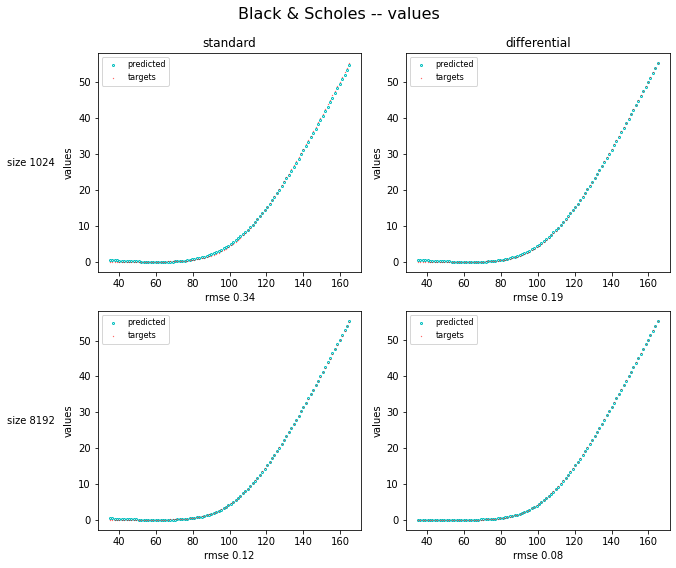

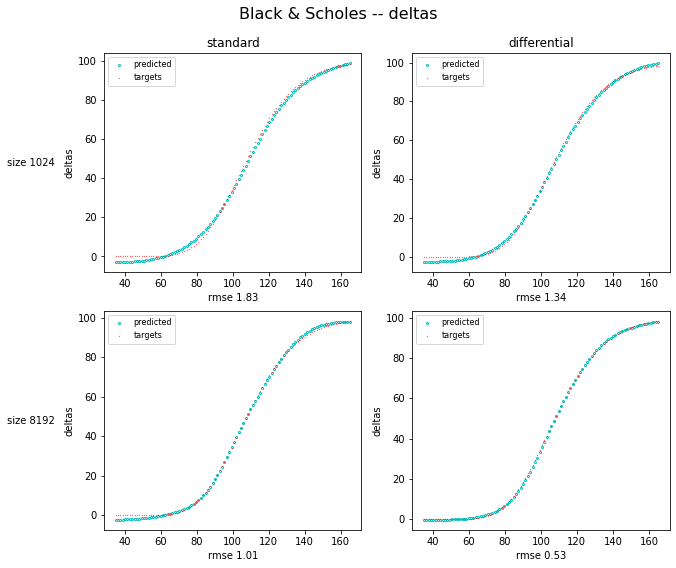

In [ ]:
# show predicitions
graph("Black & Scholes", values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("Black & Scholes", deltas, xAxis, "", "deltas", dydxTest, sizes, True)

#Bachelier model

In [ ]:
# helper analytics
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return  vol * np.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return np.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(n):
    randoms = np.random.uniform(low=-1., high=1., size=(2*n, n))
    cov = randoms.T @ randoms
    invvols = np.diag(1. / np.sqrt(np.diagonal(cov)))
    return np.linalg.multi_dot([invvols, cov, invvols])
#

class Bachelier:
    
    def __init__(self, 
                 n,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.n = n
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                
    # training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
    def trainingSet(self, m, anti=True, seed=None, bktVol=0.2):
    
        np.random.seed(seed)

        # spots all currently 1, without loss of generality
        self.S0 = np.repeat(1., self.n)
        # random correl
        self.corr = genCorrel(self.n)

        # random weights
        self.a = np.random.uniform(low=1., high=10., size=self.n)
        self.a /= np.sum(self.a)
        # random vols
        vols = np.random.uniform(low=5., high = 50., size = self.n)
        # normalize vols for a given volatility of basket, 
        # helps with charts without loss of generality
        avols = (self.a * vols).reshape((-1,1))
        v = np.sqrt(np.linalg.multi_dot([avols.T, self.corr, avols]).reshape(1))
        self.vols = vols * bktVol / v
        self.bktVol = bktVol

        # Choleski etc. for simulation
        diagv = np.diag(self.vols)
        self.cov = np.linalg.multi_dot([diagv, self.corr, diagv])
        self.chol = np.linalg.cholesky(self.cov) * np.sqrt(self.T2 - self.T1)
        # increase vols for simulation of X so we have more samples in the wings
        self.chol0 = self.chol * self.volMult * np.sqrt(self.T1 / (self.T2 - self.T1))
        # simulations
        normals = np.random.normal(size=[2, m, self.n])
        inc0 = normals[0, :, :] @ self.chol0.T
        inc1 = normals[1, :, :] @ self.chol.T
    
        S1 = self.S0 + inc0
        
        S2 = S1 + inc1
        bkt2 = np.dot(S2, self.a)
        pay = np.maximum(0, bkt2 - self.K)

        # two antithetic paths
        if anti:
            
            S2a = S1 - inc1
            bkt2a = np.dot(S2a, self.a)
            paya = np.maximum(0, bkt2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z2 =  np.where(bkt2a > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            
        return X, Y.reshape(-1,1), Z
    
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas
    def testSet(self, lower=0.5, upper=1.50, num=4096, seed=None):
        
        np.random.seed(seed)
        # adjust lower and upper for dimension
        adj = 1 + 0.5 * np.sqrt((self.n-1)*(upper-lower)/12)
        adj_lower = 1.0 - (1.0-lower) * adj
        adj_upper = 1.0 + (upper - 1.0) * adj
        # draw spots
        spots = np.random.uniform(low=adj_lower, high = adj_upper, size=(num, self.n))
        # compute baskets, prices, deltas and vegas
        baskets = np.dot(spots, self.a).reshape((-1, 1))
        prices = bachPrice(baskets, self.K, self.bktVol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bachDelta(baskets, self.K, self.bktVol, self.T2 - self.T1) @ self.a.reshape((1, -1))
        vegas = bachVega(baskets, self.K, self.bktVol, self.T2 - self.T1) 
        return spots, baskets, prices, deltas, vegas

In [ ]:
# basket / bachelier dimension
basketDim = 1

# simulation set sizes to perform
sizes = [1024, 8192]

# show delta?
showDeltas = True
deltidx = 0 # show delta to first stock

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
testSeed = None
weightSeed = None
    
# number of test scenarios
nTest = 4096    

# go
generator = Bachelier(basketDim)
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 8414
simulating training, valid and test sets
done
initializing neural appropximator
done

size 1024




size 8192


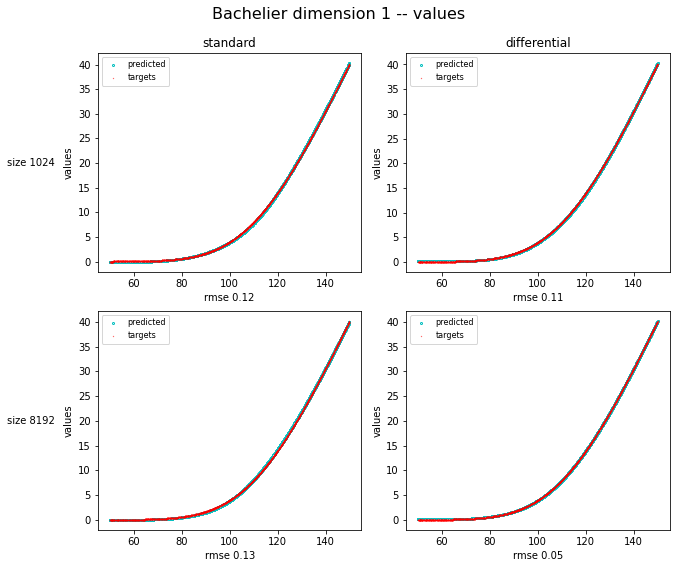

In [ ]:
# show predicitions
graph("Bachelier dimension %d" % basketDim, values, xAxis, "", "values", yTest, sizes, True)

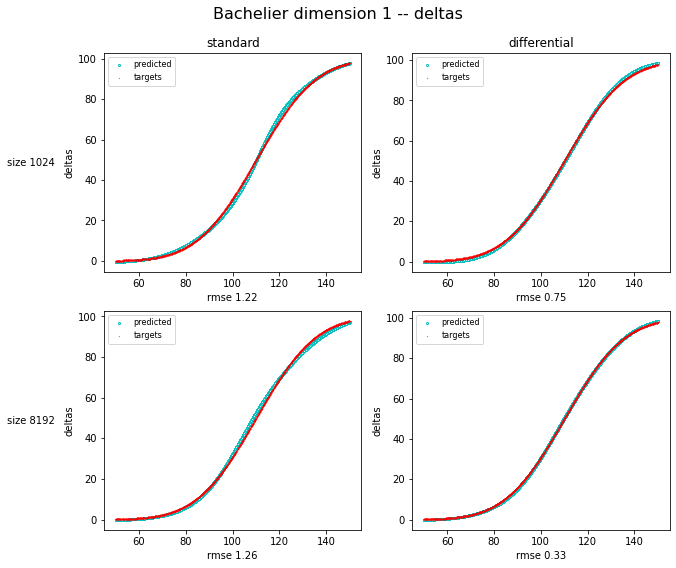

In [ ]:
# show deltas
if showDeltas:
    graph("Bachelier dimension %d" % basketDim, deltas, xAxis, "", "deltas", dydxTest, sizes, True)

In [ ]:
# basket / bachelier dimension
basketDim = 9

# simulation set sizes to perform
sizes = [1024, 8192, 16384]
print(sizes[2])

# show delta?
showDeltas = True
deltidx = 0 # show delta to first stock

# seed
simulSeed = 124
# simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
testSeed = None
weightSeed = None
    
# number of test scenarios
nTest = 4096    

# go
generator = Bachelier(basketDim)
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

16384
using seed 124
simulating training, valid and test sets
done
initializing neural appropximator
done

size 1024




size 8192




size 16384


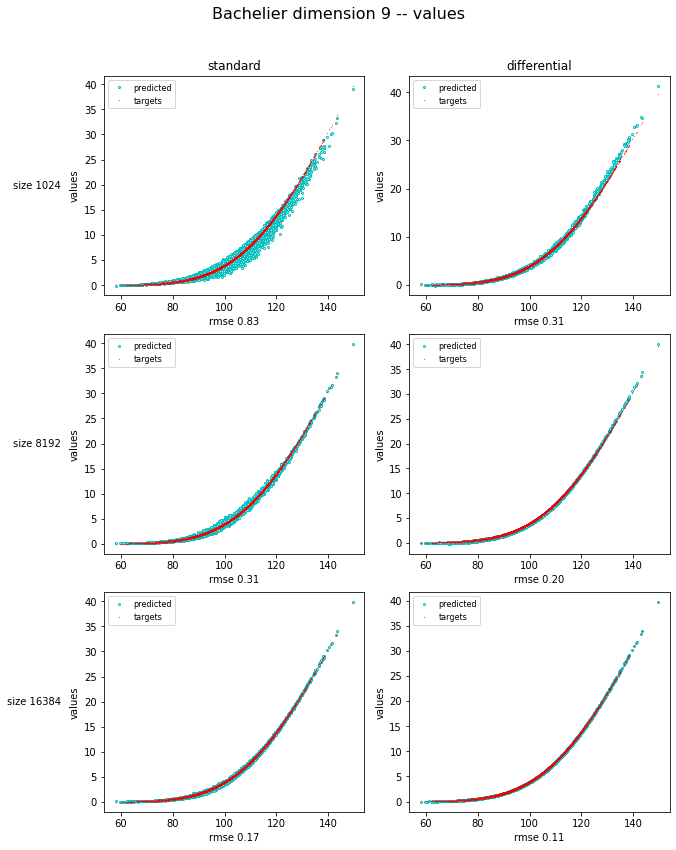

NameError: ignored

In [ ]:
# show predicitions
graph("Bachelier dimension %d" % basketDim, values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("Bachelier dimension %d" % basketDim, deltas, xAxis, "", "deltas", dydxTest, sizes, True)

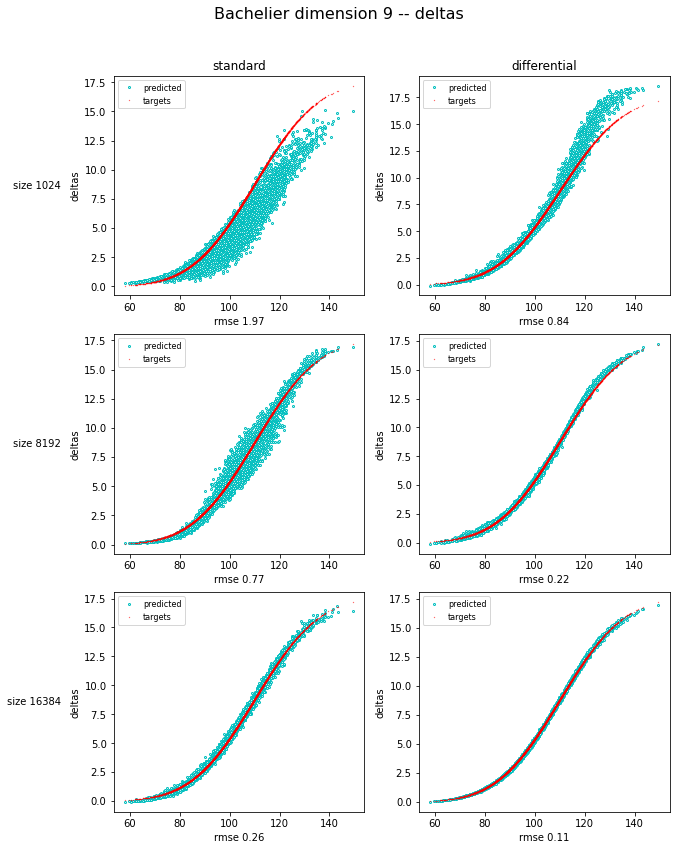

In [ ]:
# show deltas
if showDeltas:
    graph("Bachelier dimension %d" % basketDim, deltas, xAxis, "", "deltas", dydxTest, sizes, True)

##Hedge expirement

In [1]:
try:
    %matplotlib notebook
except Exception:
    pass

# import and test
import tensorflow as tf2
print("TF version =", tf2.__version__)

# we want TF 2.x
assert tf2.__version__ >= "2.0"

# disable eager execution etc
tf = tf2.compat.v1
tf.disable_eager_execution()
from numpy import random
# disable annoying warnings
tf.logging.set_verbosity(tf.logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

# make sure we have GPU support
print("GPU support = ", tf.test.is_gpu_available())

# import other useful libs
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
from tqdm import tqdm_notebook

# representation of real numbers in TF, change here for 32/64 bits
real_type = tf.float32
# real_type = tf.float64

TF version = 2.5.0
GPU support =  False


In [2]:

def vanilla_net(
    input_dim,      # dimension of inputs, e.g. 10
    hidden_units,   # units in hidden layers, assumed constant, e.g. 20
    hidden_layers,  # number of hidden layers, e.g. 4
    seed):          # seed for initialization or None for random
    
    # set seed
    tf.set_random_seed(seed)
    
    # input layer
    xs = tf.placeholder(shape=[None, input_dim], dtype=real_type)
    
    # connection weights and biases of hidden layers
    ws = [None]
    bs = [None]
    # layer 0 (input) has no parameters
    
    # layer 0 = input layer
    zs = [xs] # eq.3, l=0
    
    # first hidden layer (index 1)
    # weight matrix
    ws.append(tf.get_variable("w1", [input_dim, hidden_units], \
        initializer = tf.variance_scaling_initializer(), dtype=real_type))
    # bias vector
    bs.append(tf.get_variable("b1", [hidden_units], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # graph
    zs.append(zs[0] @ ws[1] + bs[1]) # eq. 3, l=1
    
    # second hidden layer (index 2) to last (index hidden_layers)
    for l in range(1, hidden_layers): 
        ws.append(tf.get_variable("w%d"%(l+1), [hidden_units, hidden_units], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
        bs.append(tf.get_variable("b%d"%(l+1), [hidden_units], \
            initializer = tf.zeros_initializer(), dtype=real_type))
        zs.append(tf.nn.softplus(zs[l]) @ ws[l+1] + bs[l+1]) # eq. 3, l=2..L-1

    # output layer (index hidden_layers+1)
    ws.append(tf.get_variable("w"+str(hidden_layers+1), [hidden_units, 1], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
    bs.append(tf.get_variable("b"+str(hidden_layers+1), [1], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # eq. 3, l=L
    zs.append(tf.nn.softplus(zs[hidden_layers]) @ ws[hidden_layers+1] + bs[hidden_layers+1]) 
    
    # result = output layer
    ys = zs[hidden_layers+1]
    
    # return input layer, (parameters = weight matrices and bias vectors), 
    # [all layers] and output layer
    return xs, (ws, bs), zs, ys

In [3]:
# compute d_output/d_inputs by (explicit) backprop in vanilla net
def backprop(
    weights_and_biases, # 2nd output from vanilla_net() 
    zs):                # 3rd output from vanilla_net()
    
    ws, bs = weights_and_biases
    L = len(zs) - 1
    
    # backpropagation, eq. 4, l=L..1
    zbar = tf.ones_like(zs[L]) # zbar_L = 1
    for l in range(L-1, 0, -1):
        zbar = (zbar @ tf.transpose(ws[l+1])) * tf.nn.sigmoid(zs[l]) # eq. 4
    # for l=0
    zbar = zbar @ tf.transpose(ws[1]) # eq. 4
    
    xbar = zbar # xbar = zbar_0
    
    # dz[L] / dx
    return xbar    

# combined graph for valuation and differentiation
def twin_net(input_dim, hidden_units, hidden_layers, seed):
    
    # first, build the feedforward net
    xs, (ws, bs), zs, ys = vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # then, build its differentiation by backprop
    xbar = backprop((ws, bs), zs)
    
    # return input x, output y and differentials d_y/d_z
    return xs, ys, xbar

In [4]:
def vanilla_training_graph(input_dim, hidden_units, hidden_layers, seed):
    
    # net
    inputs, weights_and_biases, layers, predictions = \
        vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # backprop even though we are not USING differentials for training
    # we still need them to predict derivatives dy_dx 
    derivs_predictions = backprop(weights_and_biases, layers)
    
    # placeholder for labels
    labels = tf.placeholder(shape=[None, 1], dtype=real_type)
    
    # loss 
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    # optimizer
    learning_rate = tf.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary 
    return inputs, labels, predictions, derivs_predictions, learning_rate, loss, optimizer.minimize(loss)

# training loop for one epoch
def vanilla_train_one_epoch(# training graph from vanilla_training_graph()
                            inputs, labels, lr_placeholder, minimizer,   
                            # training set 
                            x_train, y_train,                           
                            # params, left to client code
                            learning_rate, batch_size, session):        
    
    m, n = x_train.shape
    
    # minimization loop over mini-batches
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

In [5]:
def diff_training_graph(
    # same as vanilla
    input_dim, 
    hidden_units, 
    hidden_layers, 
    seed, 
    # balance relative weight of values and differentials 
    # loss = alpha * MSE(values) + beta * MSE(greeks, lambda_j) 
    # see online appendix
    alpha, 
    beta,
    lambda_j):
    
    # net, now a twin
    inputs, predictions, derivs_predictions = twin_net(input_dim, hidden_units, hidden_layers, seed)
    
    # placeholder for labels, now also derivs labels
    labels = tf.placeholder(shape=[None, 1], dtype=real_type)
    derivs_labels = tf.placeholder(shape=[None, derivs_predictions.shape[1]], dtype=real_type)
    
    # loss, now combined values + derivatives
    loss = alpha * tf.losses.mean_squared_error(labels, predictions) \
    + beta * tf. losses.mean_squared_error(derivs_labels * lambda_j, derivs_predictions * lambda_j)
    
    # optimizer, as vanilla
    learning_rate = tf.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary tensors, including derivatives
    # predictions and labels
    return inputs, labels, derivs_labels, predictions, derivs_predictions, \
            learning_rate, loss, optimizer.minimize(loss)

def diff_train_one_epoch(inputs, labels, derivs_labels, 
                         # graph
                         lr_placeholder, minimizer,             
                         # training set, extended
                         x_train, y_train, dydx_train,          
                         # params
                         learning_rate, batch_size, session):   
    
    m, n = x_train.shape
    
    # minimization loop, now with Greeks
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            derivs_labels: dydx_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

In [6]:
def train(description,
          # neural approximator
          approximator,              
          # training params
          reinit=True, 
          epochs=100, 
          # one-cycle learning rate schedule
          learning_rate_schedule=[    (0.0, 1.0e-8), \
                                      (0.2, 0.1),    \
                                      (0.6, 0.01),   \
                                      (0.9, 1.0e-6), \
                                      (1.0, 1.0e-8)  ], 
          batches_per_epoch=16,
          min_batch_size=256,
          # callback function and when to call it
          callback=None,           # arbitrary callable
          callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
    # batching
    batch_size = max(min_batch_size, approximator.m // batches_per_epoch)
    
    # one-cycle learning rate sechedule
    lr_schedule_epochs, lr_schedule_rates = zip(*learning_rate_schedule)
            
    # reset
    if reinit:
        approximator.session.run(approximator.initializer)
    
    # callback on epoch 0, if requested
    if callback and 0 in callback_epochs:
        callback(approximator, 0)
        
    # loop on epochs, with progress bar (tqdm)
    for epoch in tqdm_notebook(range(epochs), desc=description):
        
        # interpolate learning rate in cycle
        learning_rate = np.interp(epoch / epochs, lr_schedule_epochs, lr_schedule_rates)
        
        # train one epoch
        
        if not approximator.differential:
        
            vanilla_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                learning_rate, 
                batch_size, 
                approximator.session)
        
        else:
        
            diff_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.derivs_labels,
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                approximator.dy_dx,
                learning_rate, 
                batch_size, 
                approximator.session)
        
        # callback, if requested
        if callback and epoch in callback_epochs:
            callback(approximator, epoch)

    # final callback, if requested
    if callback and epochs in callback_epochs:
        callback(approximator, epochs)

In [7]:
# basic data preparation
epsilon = 1.0e-08
def normalize_data(x_raw, y_raw, dydx_raw=None, crop=None):
    
    # crop dataset
    m = crop if crop is not None else x_raw.shape[0]
    x_cropped = x_raw[:m]
    y_cropped = y_raw[:m]
    dycropped_dxcropped = dydx_raw[:m] if dydx_raw is not None else None
    
    # normalize dataset
    x_mean = x_cropped.mean(axis=0)
    x_std = x_cropped.std(axis=0) + epsilon
    x = (x_cropped- x_mean) / x_std
    y_mean = y_cropped.mean(axis=0)
    y_std = y_cropped.std(axis=0) + epsilon
    y = (y_cropped-y_mean) / y_std
    
    # normalize derivatives too
    if dycropped_dxcropped is not None:
        dy_dx = dycropped_dxcropped / y_std * x_std 
        # weights of derivatives in cost function = (quad) mean size
        lambda_j = 1.0 / np.sqrt((dy_dx ** 2).mean(axis=0)).reshape(1, -1)
    else:
        dy_dx = None
        lambda_j = None
    
    return x_mean, x_std, x, y_mean, y_std, y, dy_dx, lambda_j

In [8]:
class Neural_Approximator():
    
    def __init__(self, x_raw, y_raw, 
                 dydx_raw=None):      # derivatives labels, 
       
        self.x_raw = x_raw
        self.y_raw = y_raw
        self.dydx_raw = dydx_raw
        
        # tensorflow logic
        self.graph = None
        self.session = None
                        
    def __del__(self):
        if self.session is not None:
            self.session.close()
        
    def build_graph(self,
                differential,       # differential or not           
                lam,                # balance cost between values and derivs  
                hidden_units, 
                hidden_layers, 
                weight_seed):
        
        # first, deal with tensorflow logic
        if self.session is not None:
            self.session.close()

        self.graph = tf.Graph()
        
        with self.graph.as_default():
        
            # build the graph, either vanilla or differential
            self.differential = differential
            
            if not differential:
            # vanilla 
                
                self.inputs, \
                self.labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer \
                = vanilla_training_graph(self.n, hidden_units, hidden_layers, weight_seed)
                    
            else:
            # differential
            
                if self.dy_dx is None:
                    raise Exception("No differential labels for differential training graph")
            
                self.alpha = 1.0 / (1.0 + lam * self.n)
                self.beta = 1.0 - self.alpha
                
                self.inputs, \
                self.labels, \
                self.derivs_labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer = diff_training_graph(self.n, hidden_units, \
                                                     hidden_layers, weight_seed, \
                                                     self.alpha, self.beta, self.lambda_j)
        
            # global initializer
            self.initializer = tf.global_variables_initializer()
            
        # done
        self.graph.finalize()
        self.session = tf.Session(graph=self.graph)
                        
    # prepare for training with m examples, standard or differential
    def prepare(self, 
                m, 
                differential,
                lam=1,              # balance cost between values and derivs  
                # standard architecture
                hidden_units=20, 
                hidden_layers=2, 
                weight_seed=None):

        # prepare dataset
        self.x_mean, self.x_std, self.x, self.y_mean, self.y_std, self.y, self.dy_dx, self.lambda_j = \
            normalize_data(self.x_raw, self.y_raw, self.dydx_raw, m)
        
        # build graph        
        self.m, self.n = self.x.shape        
        self.build_graph(differential, lam, hidden_units, hidden_layers, weight_seed)
        
    def train(self,            
              description="training",
              # training params
              reinit=True, 
              epochs=100, 
              # one-cycle learning rate schedule
              learning_rate_schedule=[
                  (0.0, 1.0e-8), 
                  (0.2, 0.1), 
                  (0.6, 0.01), 
                  (0.9, 1.0e-6), 
                  (1.0, 1.0e-8)], 
              batches_per_epoch=16,
              min_batch_size=256,
              # callback and when to call it
              # we don't use callbacks, but this is very useful, e.g. for debugging
              callback=None,           # arbitrary callable
              callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
        train(description, 
              self, 
              reinit, 
              epochs, 
              learning_rate_schedule, 
              batches_per_epoch, 
              min_batch_size,
              callback, 
              callback_epochs)
     
    def predict_values(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std 
        # predict scaled
        y_scaled = self.session.run(self.predictions, feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        return y

    def predict_values_and_derivs(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std
        # predict scaled
        y_scaled, dyscaled_dxscaled = self.session.run(
            [self.predictions, self.derivs_predictions], 
            feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        dydx = self.y_std / self.x_std * dyscaled_dxscaled
        return y, dydx

In [9]:
# helper analytics    
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return  vol * np.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return np.sqrt(T) * norm.pdf(d)
#
    
# main class
class Bachelier:
    
    def __init__(self, 
                 vol=0.2,
                 T1=1, 
                 T2=2, 
                 K=1,
                 volMult=1.5):
        
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, hedgingtime,  anti=True, seed=None):
    
        #np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2])

        # SDE
        vol0 = self.vol * self.volMult
        R1 = vol0*np.sqrt(self.T1)*returns[:,0]
        R2 = self.vol*np.sqrt(hedgingtime)*returns[:,1]
        S1 = self.spot + R1
        S2 = S1 + R2 

        # payoff
        pay = np.maximum(0, S2 - self.K)
        
        # two antithetic paths
        if anti:
            
            R2a = -1* self.vol*np.sqrt(hedgingtime)*returns[:,1]
            S2a = S1 + R2a             
            paya = np.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(S2 > self.K, 1.0, 0.0).reshape((-1,1)) 
            Z2 =  np.where(S2a > self.K, 1.0, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(S2 > self.K, 1.0, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas and vegas
    def testSet(self,startprice,hedgingtime, lower=0.35, upper=1.65, num=100, seed=10):
        
        spots = startprice.reshape((-1, 1))
        Normals = random.normal(0,1,4000).reshape((-1, 1))
        StockPrice = spots + self.vol*np.sqrt(1/52)*Normals
        # compute prices, deltas and vegas
        prices = bachPrice(spots, self.K, self.vol, hedgingtime).reshape((-1, 1))
        deltas = bachDelta(spots, self.K, self.vol, hedgingtime).reshape((-1, 1))
        vegas = bachVega(spots, self.K, self.vol, hedgingtime).reshape((-1, 1))
        return spots, spots, prices, deltas, vegas, StockPrice, Normals

In [10]:
def test(generator, 
         sizes, 
         nTest,
         startprice,
         hedgingtime,
         simulSeed=None, 
         testSeed=None, 
         weightSeed=None, 
         deltidx=0):

    # simulation
    print("simulating training, valid and test sets")
    xTrain, yTrain, dydxTrain = generator.trainingSet(max(sizes),hedgingtime, seed=simulSeed)
    xTest, xAxis, yTest, dydxTest, vegas, StockPrice, Normals  = generator.testSet(startprice,hedgingtime, num=nTest, seed=testSeed)
    print("done")

    # neural approximator
    print("initializing neural appropximator")
    regressor = Neural_Approximator(xTrain, yTrain, dydxTrain)
    print("done")
    
    predvalues = {}    
    preddeltas = {}
    for size in sizes:        
            
        print("\nsize %d" % size)
        regressor.prepare(size, False, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("standard training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("standard", size)] = predictions
        preddeltas[("standard", size)] = deltas[:, deltidx]
        t1 = time.time()
        
        regressor.prepare(size, True, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("differential training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("differential", size)] = predictions
        preddeltas[("differential", size)] = deltas[:, deltidx]
        t1 = time.time()
        
    return xAxis, yTest, dydxTest[:, deltidx], vegas, predvalues, preddeltas, StockPrice

def graph(title, 
          predictions, 
          xAxis, 
          xAxisName, 
          yAxisName, 
          targets, 
          sizes, 
          computeRmse=False, 
          weights=None):
    
    numRows = len(sizes)
    numCols = 2

    fig, ax = plt.subplots(numRows, numCols, squeeze=False)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), 
          xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    ax[0,0].set_title("standard")
    ax[0,1].set_title("differential")
    
    for i, size in enumerate(sizes):        
        for j, regType, in enumerate(["standard", "differential"]):

            if computeRmse:
                errors = 100 * (predictions[(regType, size)] - targets)
                if weights is not None:
                    errors /= weights
                rmse = np.sqrt((errors ** 2).mean(axis=0))
                t = "rmse %.2f" % rmse
            else:
                t = xAxisName
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size)]*100, 'co', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle("% s -- %s" % (title, yAxisName), fontsize=16)
    plt.show()

In [13]:
# simulation set sizes to perform
sizes = [100]

# show delta?
showDeltas = True

# seed
simulSeed = random.seed(1)
#simulSeed = np.random.randint(0, 10000) 
#print("using seed %d" % simulSeed)
weightSeed = random.seed(1)

# number of test scenarios
nTest = 4000
generator = Bachelier()
xAxis, yTest, dydxTest, vegas, values, deltas, StockPrice = \
    test(generator, sizes, nTest,np.ones(nTest),1, simulSeed, None, weightSeed)    
Initialprice = yTest
Vpf = yTest
a = deltas[("differential", max(sizes))].reshape((-1, 1))
b = Vpf - a
for i in range(1,52):
  Vpf = b + StockPrice*a
  hedgingtime = 1-(i/52)
  startprice = StockPrice

  generator = Bachelier()
  xAxis, yTest, dydxTest, vegas, values, deltas, StockPrice = \
      test(generator, sizes, nTest, startprice,hedgingtime, simulSeed, None, weightSeed)


  a = deltas[("differential", max(sizes))].reshape((-1, 1))
  b = Vpf - a*startprice 

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

simulating training, valid and test sets
done
initializing neural appropximator
done

size 100


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

differential training:   0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
K = 1
Vpf = StockPrice*a+b 
CallPayoff = np.maximum(StockPrice-K,0)

z = np.std(CallPayoff-Vpf)/Initialprice[1]
print(z)

[0.18600851]
